In [1]:
import os

USE_CPU = False  # Cambiar a False para intentar usar GPU

if USE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    print(" Usando CPU")
    
else:
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    print(" Usando GPU")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reducir mensajes de TensorFlow

 Usando GPU


# Taller 3 - Predicción de Series Temporales con LSTM y GRU
## Análisis Completo de Experimentos

Objetivos:
1. Implementar modelos LSTM y GRU para predicción de precios de acciones
2. Entrenar modelos con diferentes configuraciones de hiperparámetros
3. Comparar resultados entre LSTM y GRU
4. Evaluar modelos apilados (stacked) vs simples
5. Analizar métricas: MSE, MAE, RMSE, R², MAPE

Estructura del notebook:
- Parte 1: Configuración e importaciones
- Parte 2: Carga y exploración de datos
- Parte 3: Experimentos con LSTM (6 configuraciones)
- Parte 4: Experimentos con GRU (6 configuraciones)
- Parte 5: Experimentos con modelos apilados (4 configuraciones)
- Parte 6: Análisis comparativo y respuestas del taller

---
## Parte 1: Configuración e Importaciones

In [2]:
# Importaciones necesarias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Importar módulos del proyecto
from data_loader import load_and_prepare_data
from preprocessing import prepare_sequences_for_training
from models import create_lstm_model, create_gru_model, create_stacked_lstm_model, create_stacked_gru_model
from utils import create_callbacks, evaluate_model, save_model_info, compare_models
from visualize import (
    plot_average_price, plot_data_splits, plot_training_history,
    plot_predictions, plot_residuals, plot_model_comparison
)

# Configuración de visualización
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# Configurar directorio de salida y subdirectorios
OUTPUT_DIR = 'output'
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
IMAGES_DIR = os.path.join(OUTPUT_DIR, 'images')

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

print("Módulos importados correctamente")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Images directory: {IMAGES_DIR}")

I0000 00:00:1763080509.652765  205427 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Módulos importados correctamente
Output directory: output


I0000 00:00:1763080510.605768  205427 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


---
## Parte 2: Carga y Exploración de Datos

### 2.1 Selección del Archivo de Datos

Elegir un archivo de la carpeta `dataset/Data/Stocks/` o `dataset/Data/ETFs/`.
Por defecto usaremos Apple (aapl.us.txt) como ejemplo.

In [3]:
# Seleccionar archivo de stock
STOCK_FILE = 'dataset/Data/Stocks/aapl.us.txt'

# Verificar que el archivo existe
if os.path.exists(STOCK_FILE):
    print(f"Archivo seleccionado: {STOCK_FILE}")
    stock_name = os.path.basename(STOCK_FILE).replace('.us.txt', '').upper()
    print(f"Stock: {stock_name}")
else:
    print(f"ERROR: El archivo {STOCK_FILE} no existe")
    print("\nArchivos disponibles en dataset/Data/Stocks/:")
    stocks_dir = 'dataset/Data/Stocks/'
    if os.path.exists(stocks_dir):
        files = [f for f in os.listdir(stocks_dir) if f.endswith('.txt')][:10]
        for f in files:
            print(f"  - {f}")
        print("  ...")

Archivo seleccionado: dataset/Data/Stocks/aapl.us.txt
Stock: AAPL


### 2.2 Cargar y Procesar Datos

In [4]:
# Cargar datos con splits 70/15/15
print("Cargando datos...")
data_dict = load_and_prepare_data(
    file_path=STOCK_FILE,
    train_ratio=0.70,
    val_ratio=0.15,
    test_ratio=0.15
)

# Extraer componentes
df = data_dict['df']
average_prices = data_dict['average_prices']
train_data = data_dict['train_data']
val_data = data_dict['val_data']
test_data = data_dict['test_data']
train_idx = data_dict['train_idx']
val_idx = data_dict['val_idx']
test_idx = data_dict['test_idx']

print(f"\nTotal de registros: {len(df)}")
print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")
print(f"\nPrimeras fechas: {df['Date'].iloc[0]} a {df['Date'].iloc[4]}")
print(f"Últimas fechas: {df['Date'].iloc[-5]} a {df['Date'].iloc[-1]}")

Cargando datos...

Información del Dataset: aapl.us.txt
Número total de registros: 8364
Rango de fechas: 1984-09-07 00:00:00 a 2017-11-10 00:00:00
Número de días: 12117

Estadísticas del precio promedio:
  Mínimo: $0.23
  Máximo: $174.82
  Promedio: $22.28
  Desviación estándar: $37.75

División de datos:
  Entrenamiento: 5854 muestras (70.0%)
  Validación: 1254 muestras (15.0%)
  Prueba: 1256 muestras (15.0%)

Total de registros: 8364
Train: 5854 | Val: 1254 | Test: 1256

Primeras fechas: 1984-09-07 00:00:00 a 1984-09-13 00:00:00
Últimas fechas: 2017-11-06 00:00:00 a 2017-11-10 00:00:00


### 2.3 Visualizar Serie Temporal

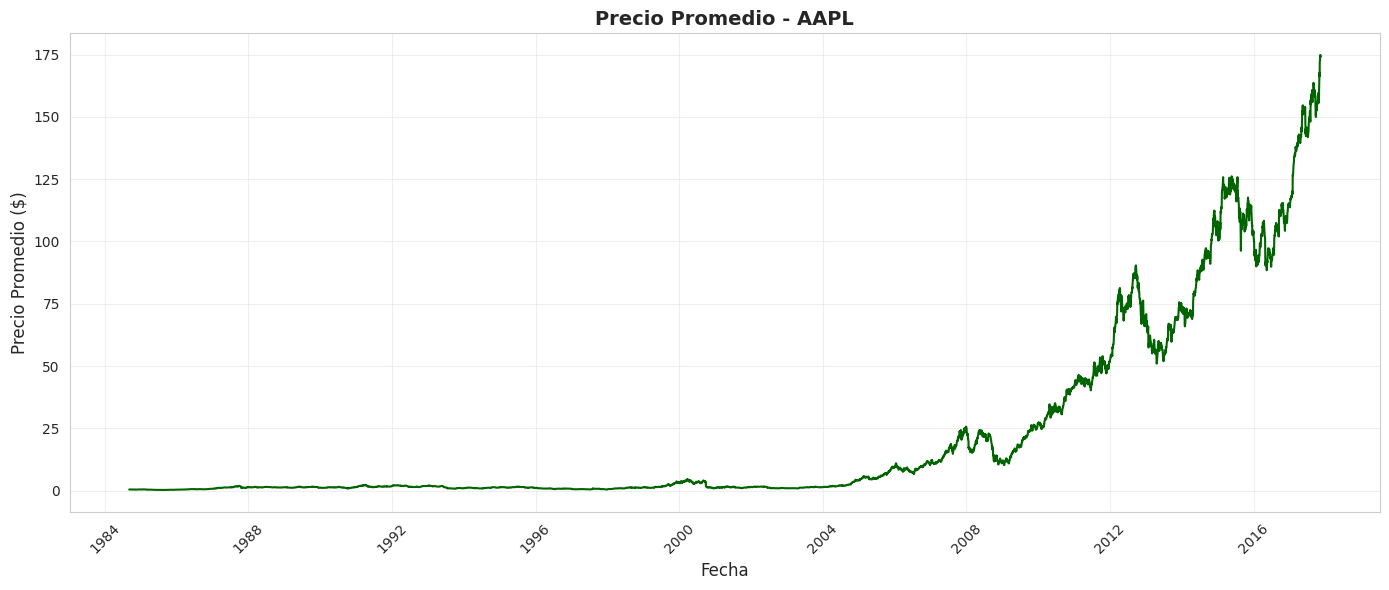

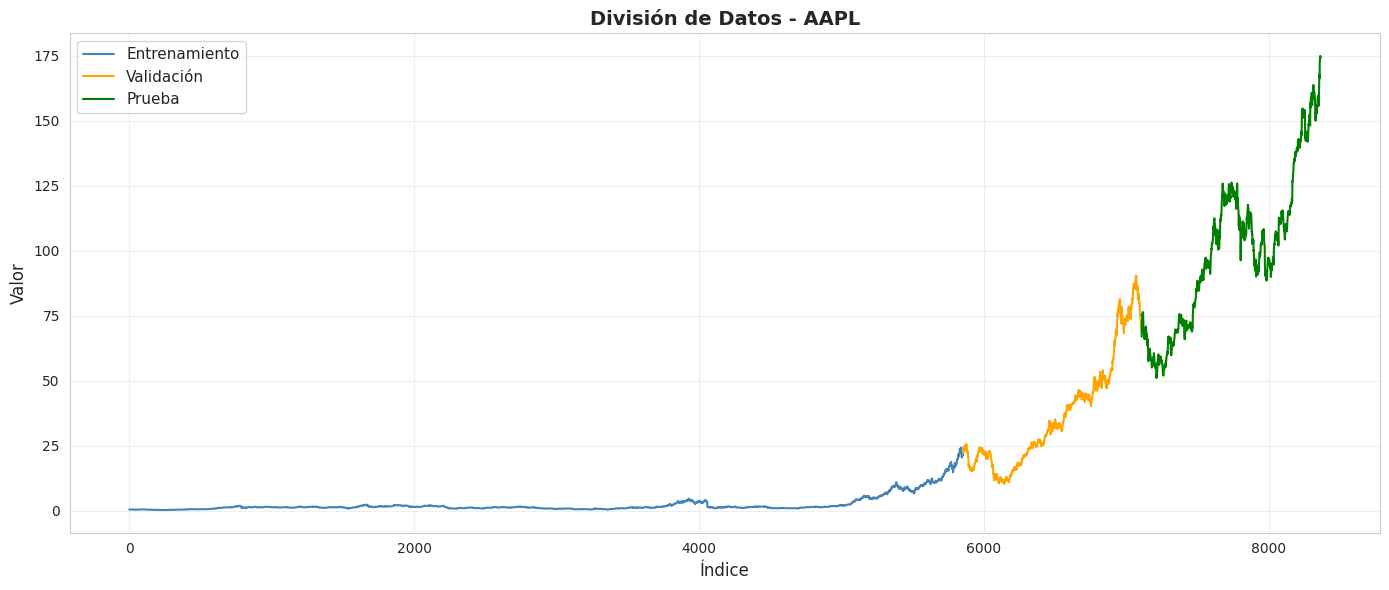


Estadísticas del precio promedio:
  Min: $0.23
  Max: $174.82
  Mean: $22.28
  Std: $37.75


In [5]:
# Graficar precio promedio completo
plot_average_price(df, stock_name)

# Graficar splits de datos
indices_dict = {
    'train': train_idx,
    'val': val_idx,
    'test': test_idx
}
plot_data_splits(
    average_prices,
    indices_dict,
    title=f"División de Datos - {stock_name}"
)

print("\nEstadísticas del precio promedio:")
print(f"  Min: ${average_prices.min():.2f}")
print(f"  Max: ${average_prices.max():.2f}")
print(f"  Mean: ${average_prices.mean():.2f}")
print(f"  Std: ${average_prices.std():.2f}")

---
## Parte 3: Experimentos con LSTM

### 3.1 Definición de Experimentos LSTM

Se definen 6 configuraciones para evaluar diferentes hiperparámetros

In [ ]:
# Array de experimentos para LSTM
lstm_experiments = [
    {
        'name': 'lstm_baseline',
        'seq_length': 60,
        'batch_size': 16,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'lstm_seq_120',
        'seq_length': 120,
        'batch_size': 16,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'lstm_seq_180',
        'seq_length': 180,
        'batch_size': 16,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'lstm_batch_32',
        'seq_length': 60,
        'batch_size': 32,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'lstm_batch_64',
        'seq_length': 60,
        'batch_size': 64,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'lstm_dropout_0_2',
        'seq_length': 60,
        'batch_size': 16,
        'units': 64,
        'recurrent_dropout': 0.2,
        'epochs': 50
    }
]

print(f"Definidos {len(lstm_experiments)} experimentos para LSTM")
for i, exp in enumerate(lstm_experiments, 1):
    print(f"  {i}. {exp['name']}: seq={exp['seq_length']}, batch={exp['batch_size']}, dropout={exp['recurrent_dropout']}")
    

Definidos 6 experimentos para LSTM
  1. LSTM Baseline: seq=60, batch=16, dropout=0.0
  2. LSTM Seq=120: seq=120, batch=16, dropout=0.0
  3. LSTM Seq=180: seq=180, batch=16, dropout=0.0
  4. LSTM Batch=32: seq=60, batch=32, dropout=0.0
  5. LSTM Batch=64: seq=60, batch=64, dropout=0.0
  6. LSTM Dropout=0.2: seq=60, batch=16, dropout=0.2


### 3.2 Ejecución de Experimentos LSTM

INICIANDO EXPERIMENTOS CON LSTM

EXPERIMENTO LSTM 1/6: LSTM Baseline
Preparando secuencias (seq_length=60)...
X_train shape: (5794, 60, 1), y_train shape: (5794,)
Creando modelo LSTM...
Entrenando con batch_size=16, epochs=50...
Epoch 1/50
362/363 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1416 - mae: 0.1266
Epoch 1: val_loss improved from None to 61.86580, saving model to output/models/lstm_baseline_best.keras
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0433 - mae: 0.0651 - val_loss: 61.8658 - val_mae: 5.1150 - learning_rate: 0.0010
Epoch 2/50
361/363 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - mae: 0.0341
Epoch 2: val_loss improved from 61.86580 to 55.31652, saving model to output/models/lstm_baseline_best.keras
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0043 - mae: 0.0318 - val_loss: 55.3165 - val_mae: 4.7625 - learning_rate: 0.0010
Epoch 3/50
360/363 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - mae: 0.0289
Epoch 3: val_loss improved from 55.31652 to 48.794

KeyboardInterrupt: 

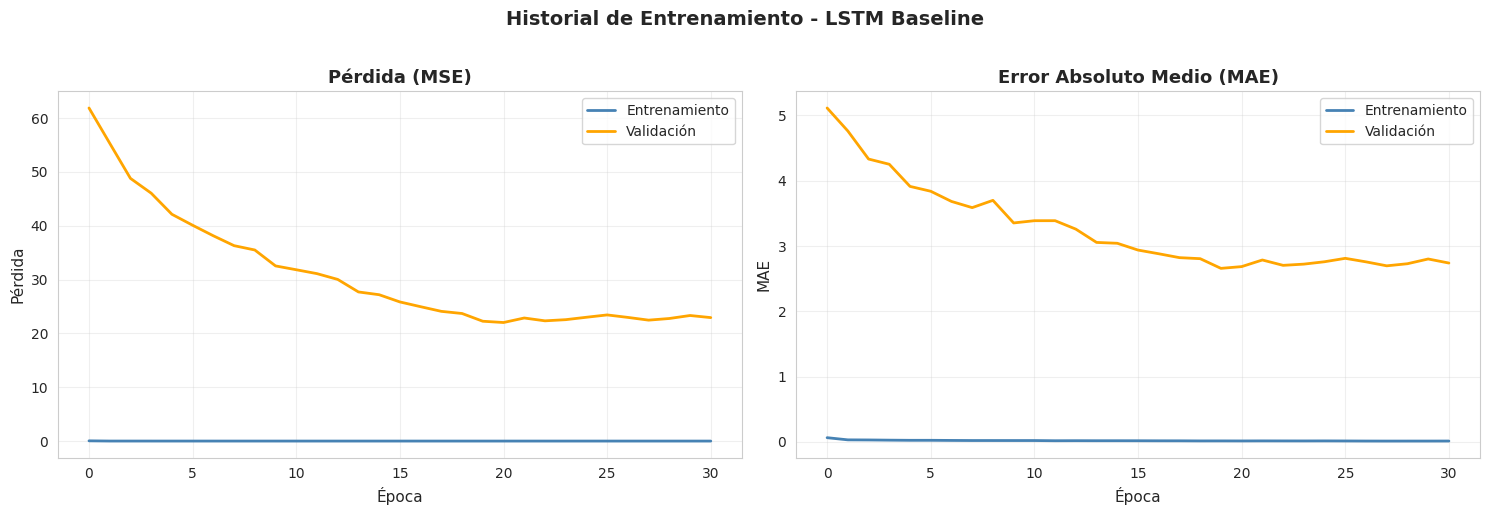

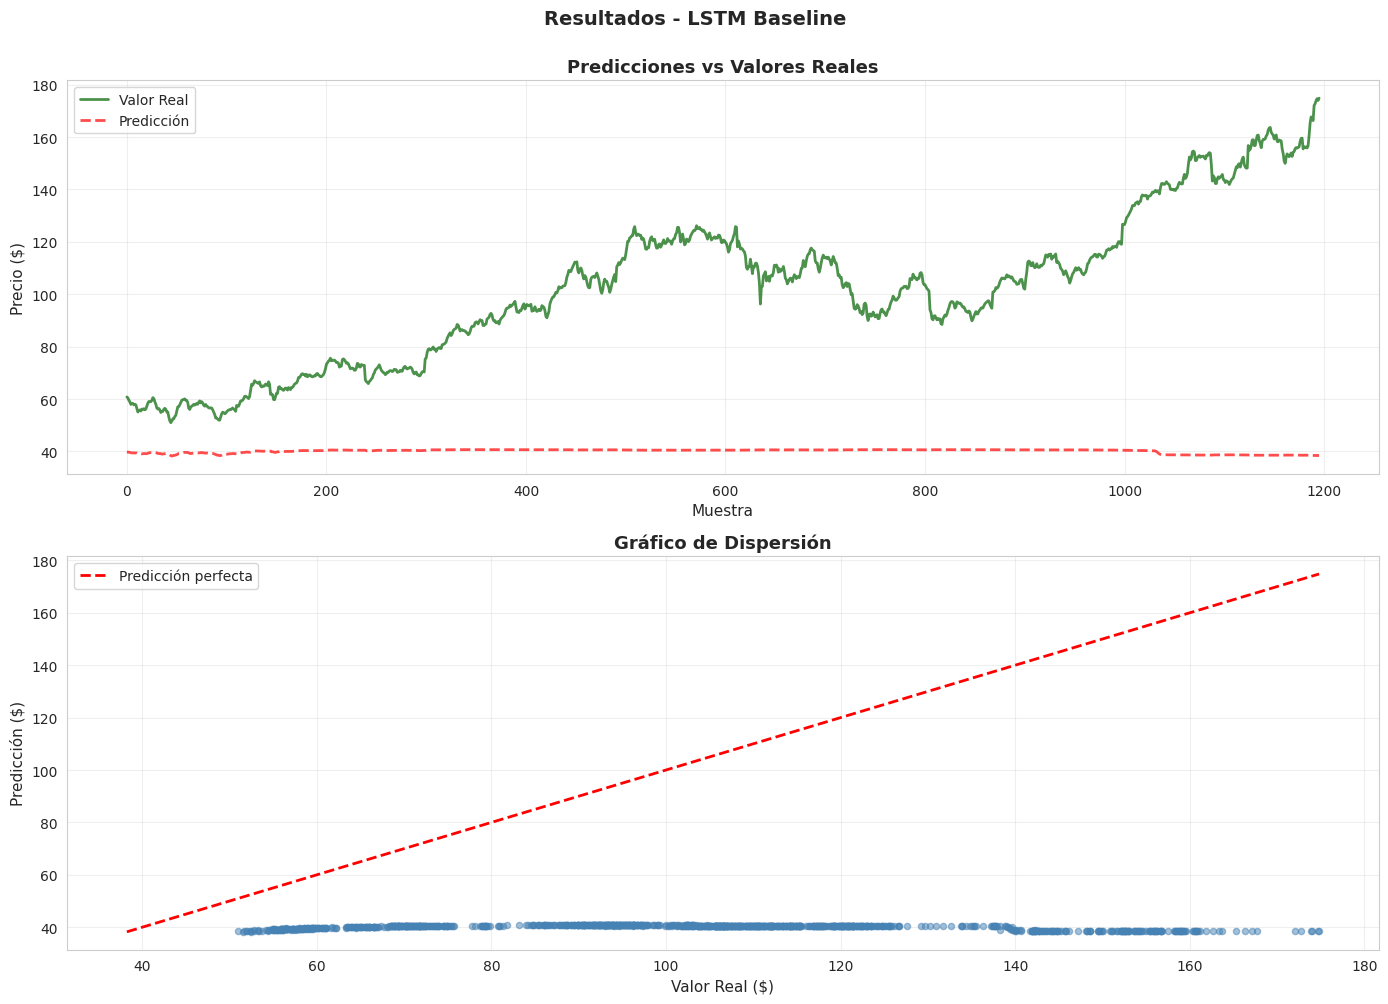

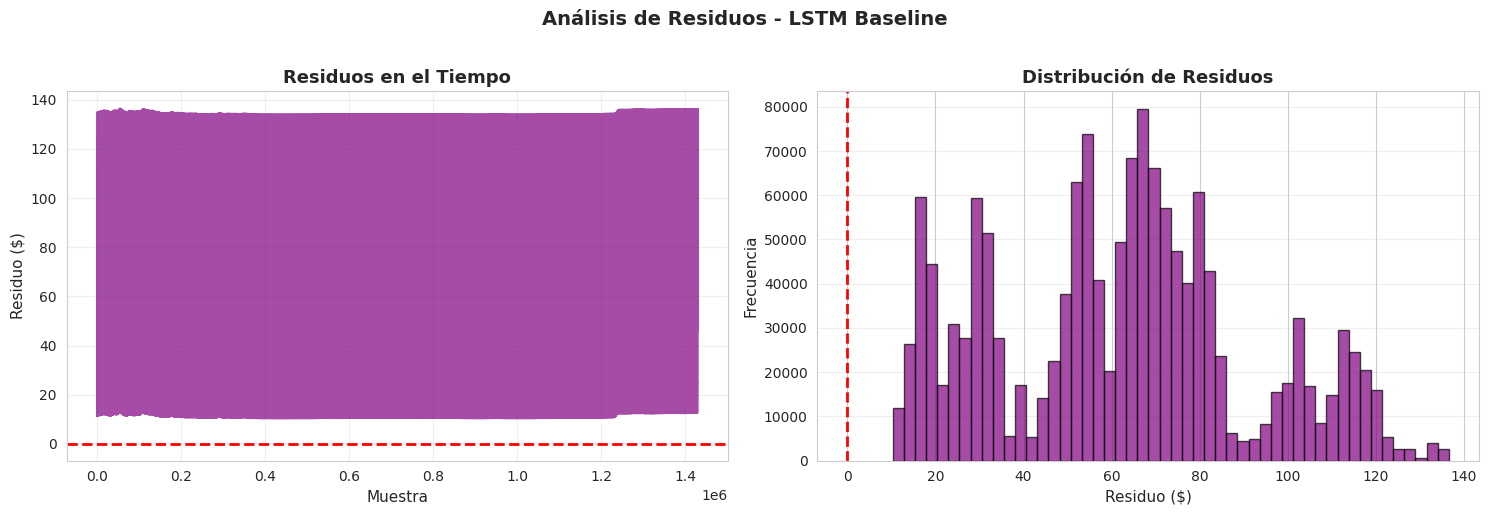

In [ ]:
# Ejecutar todos los experimentos de LSTM
lstm_results = []

print("="*80)
print("INICIANDO EXPERIMENTOS CON LSTM")
print("="*80)

for i, config in enumerate(lstm_experiments, 1):
    print(f"\n{'='*80}")
    print(f"EXPERIMENTO LSTM {i}/{len(lstm_experiments)}: {config['name']}")
    print(f"{'='*80}")
    
    # Preparar secuencias con la longitud específica
    print(f"Preparando secuencias (seq_length={config['seq_length']})...")
    sequences = prepare_sequences_for_training(
        train_data=train_data,
        val_data=val_data,
        test_data=test_data,
        seq_length=config['seq_length']
    )
    
    X_train = sequences['X_train']
    y_train = sequences['y_train']
    X_val = sequences['X_val']
    y_val = sequences['y_val']
    X_test = sequences['X_test']
    y_test = sequences['y_test']
    normalizer = sequences['normalizer']
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    
    # Crear modelo LSTM
    print("Creando modelo LSTM...")
    model = create_lstm_model(
        input_shape=(config['seq_length'], 1),
        units=config['units'],
        recurrent_dropout=config['recurrent_dropout']
    )
    
    # Crear callbacks
    model_name = config['name']
    callbacks = create_callbacks(
        model_name=model_name,
        output_dir=OUTPUT_DIR,
        patience=10
    )
    
    # Entrenar modelo
    print(f"Entrenando con batch_size={config['batch_size']}, epochs={config['epochs']}...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluar modelo
    print("\nEvaluando modelo...")
    metrics = evaluate_model(model, X_test, y_test, normalizer)
    
    print(f"\nMétricas en Test Set:")
    print(f"  MSE:  {metrics['mse']:.4f}")
    print(f"  MAE:  {metrics['mae']:.4f}")
    print(f"  RMSE: {metrics['rmse']:.4f}")
    print(f"  R²:   {metrics['r2']:.4f}")
    print(f"  MAPE: {metrics['mape']:.2f}%")
    
    # Guardar información del modelo
    save_model_info(model, config, metrics, model_name, OUTPUT_DIR)
    
    # Visualizar historial de entrenamiento
    plot_training_history(
        history, 
        config['name'],
        save_path=os.path.join(IMAGES_DIR, f"{model_name}_history.png")
    )
    
    # Hacer predicciones y visualizar
    y_pred = model.predict(X_test, verbose=0)
    y_pred_original = normalizer.inverse_transform(y_pred)
    y_test_original = normalizer.inverse_transform(y_test)
    
    plot_predictions(
        y_test_original, 
        y_pred_original, 
        config['name'],
        save_path=os.path.join(IMAGES_DIR, f"{model_name}_predictions.png")
    )
    
    plot_residuals(
        y_test_original, 
        y_pred_original, 
        config['name'],
        save_path=os.path.join(IMAGES_DIR, f"{model_name}_residuals.png")
    )
    
    # Guardar resultados
    lstm_results.append({
        'config': config,
        'model': model,
        'history': history,
        'metrics': metrics,
        'normalizer': normalizer
    })

print("\n" + "="*80)
print(f"COMPLETADOS {len(lstm_results)} EXPERIMENTOS CON LSTM")
print("="*80)

### 3.3 Comparación de Resultados LSTM

In [ ]:
# Crear DataFrame comparativo
comparison_data = []
for result in lstm_results:
    comparison_data.append({
        'Modelo': result['config']['name'],
        'MSE': result['metrics']['mse'],
        'MAE': result['metrics']['mae'],
        'RMSE': result['metrics']['rmse'],
        'R²': result['metrics']['r2'],
        'MAPE (%)': result['metrics']['mape']
    })

lstm_comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARACIÓN DE RESULTADOS - LSTM")
print("="*80)
print(lstm_comparison_df.to_string(index=False))

# Visualizar comparación
plot_model_comparison(
    lstm_comparison_df,
    metric='mape',
    title=f"Comparación de Modelos LSTM - {stock_name}",
    save_path=os.path.join(IMAGES_DIR, "lstm_comparison.png")
)

# Identificar mejor modelo
best_idx = lstm_comparison_df['MAPE (%)'].idxmin()
best_model = lstm_comparison_df.iloc[best_idx]
print(f"\nMejor modelo LSTM (menor MAPE): {best_model['Modelo']}")
print(f"  MAPE: {best_model['MAPE (%)']:.2f}%")
print(f"  R²: {best_model['R²']:.4f}")

---
## Parte 4: Experimentos con GRU

### 4.1 Definición de Experimentos GRU

Se definen 6 configuraciones equivalentes a LSTM para comparar

In [ ]:
# Array de experimentos para GRU (mismas configuraciones que LSTM)
gru_experiments = [
    {
        'name': 'gru_baseline',
        'seq_length': 60,
        'batch_size': 16,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'gru_seq_120',
        'seq_length': 120,
        'batch_size': 16,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'gru_seq_180',
        'seq_length': 180,
        'batch_size': 16,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'gru_batch_32',
        'seq_length': 60,
        'batch_size': 32,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'gru_batch_64',
        'seq_length': 60,
        'batch_size': 64,
        'units': 64,
        'recurrent_dropout': 0.0,
        'epochs': 50
    },
    {
        'name': 'gru_dropout_0_2',
        'seq_length': 60,
        'batch_size': 16,
        'units': 64,
        'recurrent_dropout': 0.2,
        'epochs': 50
    }
]

print(f"Definidos {len(gru_experiments)} experimentos para GRU")
for i, exp in enumerate(gru_experiments, 1):
    print(f"  {i}. {exp['name']}: seq={exp['seq_length']}, batch={exp['batch_size']}, dropout={exp['recurrent_dropout']}")

### 4.2 Ejecución de Experimentos GRU

In [ ]:
# Ejecutar todos los experimentos de GRU
gru_results = []

print("="*80)
print("INICIANDO EXPERIMENTOS CON GRU")
print("="*80)

for i, config in enumerate(gru_experiments, 1):
    print(f"\n{'='*80}")
    print(f"EXPERIMENTO GRU {i}/{len(gru_experiments)}: {config['name']}")
    print(f"{'='*80}")
    
    # Preparar secuencias con la longitud específica
    print(f"Preparando secuencias (seq_length={config['seq_length']})...")
    sequences = prepare_sequences_for_training(
        train_data=train_data,
        val_data=val_data,
        test_data=test_data,
        seq_length=config['seq_length']
    )
    
    X_train = sequences['X_train']
    y_train = sequences['y_train']
    X_val = sequences['X_val']
    y_val = sequences['y_val']
    X_test = sequences['X_test']
    y_test = sequences['y_test']
    normalizer = sequences['normalizer']
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    
    # Crear modelo GRU
    print("Creando modelo GRU...")
    model = create_gru_model(
        input_shape=(config['seq_length'], 1),
        units=config['units'],
        recurrent_dropout=config['recurrent_dropout']
    )
    
    # Crear callbacks
    model_name = config['name']
    callbacks = create_callbacks(
        model_name=model_name,
        output_dir=OUTPUT_DIR,
        patience=10
    )
    
    # Entrenar modelo
    print(f"Entrenando con batch_size={config['batch_size']}, epochs={config['epochs']}...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluar modelo
    print("\nEvaluando modelo...")
    metrics = evaluate_model(model, X_test, y_test, normalizer)
    
    print(f"\nMétricas en Test Set:")
    print(f"  MSE:  {metrics['mse']:.4f}")
    print(f"  MAE:  {metrics['mae']:.4f}")
    print(f"  RMSE: {metrics['rmse']:.4f}")
    print(f"  R²:   {metrics['r2']:.4f}")
    print(f"  MAPE: {metrics['mape']:.2f}%")
    
    # Guardar información del modelo
    save_model_info(model, config, metrics, model_name, OUTPUT_DIR)
    
    # Visualizar historial de entrenamiento
    plot_training_history(
        history, 
        config['name'],
        save_path=os.path.join(IMAGES_DIR, f"{model_name}_history.png")
    )
    
    # Hacer predicciones y visualizar
    y_pred = model.predict(X_test, verbose=0)
    y_pred_original = normalizer.inverse_transform(y_pred)
    y_test_original = normalizer.inverse_transform(y_test)
    
    plot_predictions(
        y_test_original, 
        y_pred_original, 
        config['name'],
        save_path=os.path.join(IMAGES_DIR, f"{model_name}_predictions.png")
    )
    
    plot_residuals(
        y_test_original, 
        y_pred_original, 
        config['name'],
        save_path=os.path.join(IMAGES_DIR, f"{model_name}_residuals.png")
    )
    
    # Guardar resultados
    gru_results.append({
        'config': config,
        'model': model,
        'history': history,
        'metrics': metrics,
        'normalizer': normalizer
    })

print("\n" + "="*80)
print(f"COMPLETADOS {len(gru_results)} EXPERIMENTOS CON GRU")
print("="*80)

### 4.3 Comparación de Resultados GRU

In [ ]:
# Crear DataFrame comparativo
comparison_data = []
for result in gru_results:
    comparison_data.append({
        'Modelo': result['config']['name'],
        'MSE': result['metrics']['mse'],
        'MAE': result['metrics']['mae'],
        'RMSE': result['metrics']['rmse'],
        'R²': result['metrics']['r2'],
        'MAPE (%)': result['metrics']['mape']
    })

gru_comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARACIÓN DE RESULTADOS - GRU")
print("="*80)
print(gru_comparison_df.to_string(index=False))

# Visualizar comparación
plot_model_comparison(
    gru_comparison_df,
    metric='mape',
    title=f"Comparación de Modelos GRU - {stock_name}",
    save_path=os.path.join(IMAGES_DIR, "gru_comparison.png")
)

# Identificar mejor modelo
best_idx = gru_comparison_df['MAPE (%)'].idxmin()
best_model = gru_comparison_df.iloc[best_idx]
print(f"\nMejor modelo GRU (menor MAPE): {best_model['Modelo']}")
print(f"  MAPE: {best_model['MAPE (%)']:.2f}%")
print(f"  R²: {best_model['R²']:.4f}")

---
## Parte 5: Experimentos con Modelos Apilados (Stacked)

### 5.1 Definición de Experimentos Stacked

Se definen 4 configuraciones para evaluar modelos apilados

In [ ]:
# Array de experimentos para modelos apilados
stacked_experiments = [
    {
        'name': 'stacked_lstm_2_layers',
        'model_type': 'lstm',
        'seq_length': 60,
        'batch_size': 16,
        'units_list': [64, 32],
        'recurrent_dropout': 0.2,
        'epochs': 50
    },
    {
        'name': 'stacked_lstm_3_layers',
        'model_type': 'lstm',
        'seq_length': 60,
        'batch_size': 16,
        'units_list': [64, 32, 16],
        'recurrent_dropout': 0.2,
        'epochs': 50
    },
    {
        'name': 'stacked_gru_2_layers',
        'model_type': 'gru',
        'seq_length': 60,
        'batch_size': 16,
        'units_list': [64, 32],
        'recurrent_dropout': 0.2,
        'epochs': 50
    },
    {
        'name': 'stacked_gru_3_layers',
        'model_type': 'gru',
        'seq_length': 60,
        'batch_size': 16,
        'units_list': [64, 32, 16],
        'recurrent_dropout': 0.2,
        'epochs': 50
    }
]

print(f"Definidos {len(stacked_experiments)} experimentos para modelos apilados")
for i, exp in enumerate(stacked_experiments, 1):
    layers_str = '-'.join(map(str, exp['units_list']))
    print(f"  {i}. {exp['name']}: {exp['model_type'].upper()} [{layers_str}], dropout={exp['recurrent_dropout']}")

### 5.2 Ejecución de Experimentos Stacked

In [ ]:
# Ejecutar todos los experimentos stacked
stacked_results = []

print("="*80)
print("INICIANDO EXPERIMENTOS CON MODELOS APILADOS")
print("="*80)

for i, config in enumerate(stacked_experiments, 1):
    print(f"\n{'='*80}")
    print(f"EXPERIMENTO STACKED {i}/{len(stacked_experiments)}: {config['name']}")
    print(f"{'='*80}")
    
    # Preparar secuencias
    print(f"Preparando secuencias (seq_length={config['seq_length']})...")
    sequences = prepare_sequences_for_training(
        train_data=train_data,
        val_data=val_data,
        test_data=test_data,
        seq_length=config['seq_length']
    )
    
    X_train = sequences['X_train']
    y_train = sequences['y_train']
    X_val = sequences['X_val']
    y_val = sequences['y_val']
    X_test = sequences['X_test']
    y_test = sequences['y_test']
    normalizer = sequences['normalizer']
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    
    # Crear modelo stacked
    print(f"Creando modelo {config['model_type'].upper()} apilado con capas {config['units_list']}...")
    if config['model_type'] == 'lstm':
        model = create_stacked_lstm_model(
            input_shape=(config['seq_length'], 1),
            units_list=config['units_list'],
            recurrent_dropout=config['recurrent_dropout']
        )
    else:  # gru
        model = create_stacked_gru_model(
            input_shape=(config['seq_length'], 1),
            units_list=config['units_list'],
            recurrent_dropout=config['recurrent_dropout']
        )
    
    # Crear callbacks
    model_name = config['name']
    callbacks = create_callbacks(
        model_name=model_name,
        output_dir=OUTPUT_DIR,
        patience=10
    )
    
    # Entrenar modelo
    print(f"Entrenando con batch_size={config['batch_size']}, epochs={config['epochs']}...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluar modelo
    print("\nEvaluando modelo...")
    metrics = evaluate_model(model, X_test, y_test, normalizer)
    
    print(f"\nMétricas en Test Set:")
    print(f"  MSE:  {metrics['mse']:.4f}")
    print(f"  MAE:  {metrics['mae']:.4f}")
    print(f"  RMSE: {metrics['rmse']:.4f}")
    print(f"  R²:   {metrics['r2']:.4f}")
    print(f"  MAPE: {metrics['mape']:.2f}%")
    
    # Guardar información del modelo
    save_model_info(model, config, metrics, model_name, OUTPUT_DIR)
    
    # Visualizar historial de entrenamiento
    plot_training_history(
        history, 
        config['name'],
        save_path=os.path.join(IMAGES_DIR, f"{model_name}_history.png")
    )
    
    # Hacer predicciones y visualizar
    y_pred = model.predict(X_test, verbose=0)
    y_pred_original = normalizer.inverse_transform(y_pred)
    y_test_original = normalizer.inverse_transform(y_test)
    
    plot_predictions(
        y_test_original, 
        y_pred_original, 
        config['name'],
        save_path=os.path.join(IMAGES_DIR, f"{model_name}_predictions.png")
    )
    
    plot_residuals(
        y_test_original, 
        y_pred_original, 
        config['name'],
        save_path=os.path.join(IMAGES_DIR, f"{model_name}_residuals.png")
    )
    
    # Guardar resultados
    stacked_results.append({
        'config': config,
        'model': model,
        'history': history,
        'metrics': metrics,
        'normalizer': normalizer
    })

print("\n" + "="*80)
print(f"COMPLETADOS {len(stacked_results)} EXPERIMENTOS CON MODELOS APILADOS")
print("="*80)

### 5.3 Comparación de Resultados Stacked

In [ ]:
# Crear DataFrame comparativo
comparison_data = []
for result in stacked_results:
    comparison_data.append({
        'Modelo': result['config']['name'],
        'MSE': result['metrics']['mse'],
        'MAE': result['metrics']['mae'],
        'RMSE': result['metrics']['rmse'],
        'R²': result['metrics']['r2'],
        'MAPE (%)': result['metrics']['mape']
    })

stacked_comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARACIÓN DE RESULTADOS - MODELOS APILADOS")
print("="*80)
print(stacked_comparison_df.to_string(index=False))

# Visualizar comparación
plot_model_comparison(
    stacked_comparison_df,
    metric='mape',
    title=f"Comparación de Modelos Apilados - {stock_name}",
    save_path=os.path.join(IMAGES_DIR, "stacked_comparison.png")
)

# Identificar mejor modelo
best_idx = stacked_comparison_df['MAPE (%)'].idxmin()
best_model = stacked_comparison_df.iloc[best_idx]
print(f"\nMejor modelo Stacked (menor MAPE): {best_model['Modelo']}")
print(f"  MAPE: {best_model['MAPE (%)']:.2f}%")
print(f"  R²: {best_model['R²']:.4f}")

---
## Parte 6: Análisis Comparativo y Respuestas al Taller

### 6.1 Comparación Global de Todos los Modelos

In [ ]:
# Combinar todos los resultados en un solo DataFrame
all_comparison_df = pd.concat([
    lstm_comparison_df,
    gru_comparison_df,
    stacked_comparison_df
], ignore_index=True)

print("="*80)
print("COMPARACIÓN GLOBAL DE TODOS LOS MODELOS")
print("="*80)
print(all_comparison_df.to_string(index=False))

# Visualizar comparación global
plot_model_comparison(
    all_comparison_df,
    metric='mape',
    title=f"Comparación Global de Todos los Modelos - {stock_name}",
    save_path=os.path.join(IMAGES_DIR, "global_comparison.png")
)

# Identificar mejores modelos
print("\n" + "="*80)
print("TOP 5 MODELOS (según MAPE)")
print("="*80)
top_5 = all_comparison_df.nsmallest(5, 'MAPE (%)')
for idx, row in top_5.iterrows():
    print(f"{idx+1}. {row['Modelo']}")
    print(f"   MAPE: {row['MAPE (%)']:.2f}% | R²: {row['R²']:.4f} | RMSE: {row['RMSE']:.4f}")

# Mejor modelo overall
best_idx = all_comparison_df['MAPE (%)'].idxmin()
best_overall = all_comparison_df.iloc[best_idx]
print(f"\n MEJOR MODELO GLOBAL: {best_overall['Modelo']}")
print(f"   MAPE: {best_overall['MAPE (%)']:.2f}%")
print(f"   R²: {best_overall['R²']:.4f}")
print(f"   RMSE: {best_overall['RMSE']:.4f}")

### 6.2 Análisis Comparativo: LSTM vs GRU

#### ¿Cuál arquitectura presenta mejor desempeño?

Comparación promedio de métricas:

In [ ]:
# Comparar promedios de LSTM vs GRU
lstm_avg = lstm_comparison_df[['MSE', 'MAE', 'RMSE', 'R²', 'MAPE (%)']].mean()
gru_avg = gru_comparison_df[['MSE', 'MAE', 'RMSE', 'R²', 'MAPE (%)']].mean()

comparison_avg = pd.DataFrame({
    'LSTM (promedio)': lstm_avg,
    'GRU (promedio)': gru_avg,
    'Diferencia': gru_avg - lstm_avg
})

print("="*80)
print("COMPARACIÓN PROMEDIO: LSTM vs GRU")
print("="*80)
print(comparison_avg)

# Determinar ganador
if lstm_avg['MAPE (%)'] < gru_avg['MAPE (%)']:
    winner = "LSTM"
    diff = gru_avg['MAPE (%)'] - lstm_avg['MAPE (%)']
else:
    winner = "GRU"
    diff = lstm_avg['MAPE (%)'] - gru_avg['MAPE (%)']

print(f"\n Ganador: {winner} (MAPE {diff:.2f}% menor)")

# Análisis por configuración
print("\n" + "="*80)
print("ANÁLISIS POR CONFIGURACIÓN")
print("="*80)

configs = ['Baseline', 'Seq=120', 'Seq=180', 'Batch=32', 'Batch=64', 'Dropout=0.2']
for i, config in enumerate(configs):
    lstm_mape = lstm_comparison_df.iloc[i]['MAPE (%)']
    gru_mape = gru_comparison_df.iloc[i]['MAPE (%)']
    better = "LSTM" if lstm_mape < gru_mape else "GRU"
    diff = abs(lstm_mape - gru_mape)
    print(f"{config:20s}: LSTM={lstm_mape:6.2f}% | GRU={gru_mape:6.2f}% | Mejor: {better:4s} (Δ={diff:.2f}%)")

### 6.3 Análisis de Hiperparámetros

#### Efecto de la longitud de secuencia (seq_length)

In [ ]:
# Analizar efecto de seq_length
seq_configs = ['Baseline', 'Seq=120', 'Seq=180']
seq_lengths = [60, 120, 180]

lstm_seq_mape = [lstm_comparison_df.iloc[i]['MAPE (%)'] for i in [0, 1, 2]]
gru_seq_mape = [gru_comparison_df.iloc[i]['MAPE (%)'] for i in [0, 1, 2]]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(seq_lengths, lstm_seq_mape, marker='o', linewidth=2, markersize=8, label='LSTM')
ax.plot(seq_lengths, gru_seq_mape, marker='s', linewidth=2, markersize=8, label='GRU')
ax.set_xlabel('Longitud de Secuencia', fontsize=12)
ax.set_ylabel('MAPE (%)', fontsize=12)
ax.set_title('Efecto de la Longitud de Secuencia en el Error', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, "seq_length_effect.png"), dpi=300, bbox_inches='tight')
plt.show()

print("EFECTO DE LONGITUD DE SECUENCIA:")
print("-" * 60)
for i, (config, seq) in enumerate(zip(seq_configs, seq_lengths)):
    print(f"Seq={seq:3d}: LSTM={lstm_seq_mape[i]:6.2f}% | GRU={gru_seq_mape[i]:6.2f}%")

#### Efecto del tamaño de batch (batch_size)

In [ ]:
# Analizar efecto de batch_size
batch_configs = ['Baseline', 'Batch=32', 'Batch=64']
batch_sizes = [16, 32, 64]

lstm_batch_mape = [lstm_comparison_df.iloc[i]['MAPE (%)'] for i in [0, 3, 4]]
gru_batch_mape = [gru_comparison_df.iloc[i]['MAPE (%)'] for i in [0, 3, 4]]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(batch_sizes, lstm_batch_mape, marker='o', linewidth=2, markersize=8, label='LSTM')
ax.plot(batch_sizes, gru_batch_mape, marker='s', linewidth=2, markersize=8, label='GRU')
ax.set_xlabel('Tamaño de Batch', fontsize=12)
ax.set_ylabel('MAPE (%)', fontsize=12)
ax.set_title('Efecto del Tamaño de Batch en el Error', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, "batch_size_effect.png"), dpi=300, bbox_inches='tight')
plt.show()

print("EFECTO DE TAMAÑO DE BATCH:")
print("-" * 60)
for i, (config, batch) in enumerate(zip(batch_configs, batch_sizes)):
    print(f"Batch={batch:2d}: LSTM={lstm_batch_mape[i]:6.2f}% | GRU={gru_batch_mape[i]:6.2f}%")

### 6.4 Análisis de Modelos Apilados

#### ¿Los modelos apilados mejoran el desempeño?

In [ ]:
# Comparar modelos simples vs apilados
simple_lstm = lstm_comparison_df.iloc[0]  # Baseline
simple_gru = gru_comparison_df.iloc[0]    # Baseline

stacked_lstm_2 = stacked_comparison_df.iloc[0]  # 2 layers
stacked_lstm_3 = stacked_comparison_df.iloc[1]  # 3 layers
stacked_gru_2 = stacked_comparison_df.iloc[2]   # 2 layers
stacked_gru_3 = stacked_comparison_df.iloc[3]   # 3 layers

comparison_stacked = pd.DataFrame({
    'Modelo': [
        'LSTM Simple',
        'LSTM Stacked 2L',
        'LSTM Stacked 3L',
        'GRU Simple',
        'GRU Stacked 2L',
        'GRU Stacked 3L'
    ],
    'MAPE (%)': [
        simple_lstm['MAPE (%)'],
        stacked_lstm_2['MAPE (%)'],
        stacked_lstm_3['MAPE (%)'],
        simple_gru['MAPE (%)'],
        stacked_gru_2['MAPE (%)'],
        stacked_gru_3['MAPE (%)']
    ],
    'R²': [
        simple_lstm['R²'],
        stacked_lstm_2['R²'],
        stacked_lstm_3['R²'],
        simple_gru['R²'],
        stacked_gru_2['R²'],
        stacked_gru_3['R²']
    ]
})

print("="*80)
print("COMPARACIÓN: MODELOS SIMPLES vs APILADOS")
print("="*80)
print(comparison_stacked.to_string(index=False))

# Visualizar comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

models = ['Simple', '2-Layers', '3-Layers']
lstm_mapes = [simple_lstm['MAPE (%)'], stacked_lstm_2['MAPE (%)'], stacked_lstm_3['MAPE (%)']]
gru_mapes = [simple_gru['MAPE (%)'], stacked_gru_2['MAPE (%)'], stacked_gru_3['MAPE (%)']]

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, lstm_mapes, width, label='LSTM', alpha=0.8)
ax1.bar(x + width/2, gru_mapes, width, label='GRU', alpha=0.8)
ax1.set_xlabel('Arquitectura', fontsize=12)
ax1.set_ylabel('MAPE (%)', fontsize=12)
ax1.set_title('Comparación: Simple vs Apilados (MAPE)', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

lstm_r2s = [simple_lstm['R²'], stacked_lstm_2['R²'], stacked_lstm_3['R²']]
gru_r2s = [simple_gru['R²'], stacked_gru_2['R²'], stacked_gru_3['R²']]

ax2.bar(x - width/2, lstm_r2s, width, label='LSTM', alpha=0.8)
ax2.bar(x + width/2, gru_r2s, width, label='GRU', alpha=0.8)
ax2.set_xlabel('Arquitectura', fontsize=12)
ax2.set_ylabel('R²', fontsize=12)
ax2.set_title('Comparación: Simple vs Apilados (R²)', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, "simple_vs_stacked.png"), dpi=300, bbox_inches='tight')
plt.show()